In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 144)

# Model Deployment

we will deploy the model trained by the dataset simulated by fvcom model, the objective is to:

1. Plot the curve of water age vs SLR in the condition of multi-approach NbS, ERA and IRA.

2. Plot the curve of water age increasement vs SLR in the condition of multi-approach NbS, ERA and IRA.

## 1. Data prepare

|      Column 	| Description                                                                    	|
|------------:	|--------------------------------------------------------------------------------	|
|       `lat` 	| Lat of points in Tokyo Bay                                                       |
|       `lon` 	| Lon of points in Tokyo Bay                                                        |
|   `sigma_z` 	| Sigma Z of points, from 1 to 20, representing sea surface to bottom 	            |
|   `slr_hgt` 	| SLR hight, from 0 to 2.0 meters.                                              	|
|  `nbs_case` 	| NbS case, we have two case, 1 for ERA, 3 for IRA.   	|

In [2]:
# read a csv file to extract lon and lat to 2 lists
ss = 0
nbs = 1
ll = 1
filepath = '../csv_files_ml_inner/c{0:02d}{1:02d}_m00_{2:02d}.csv'.format(ss,nbs,ll)
df = pd.read_csv(filepath,names=['lon','lat','water_age'],header=None,index_col=False)
lo = df.lon.tolist()
la = df.lat.tolist()
print(len(lo),len(la))

4739 4739


In [3]:
# make a long list for case: 4739 * 20 * 2
lon = lo * 20 * 2
lat = la * 20 * 2
sigma_z = [i for i in range(1,21) for _ in range(len(lo))] * 2
nbs_case = [i for i in range(1,4,2) for _ in range(len(lo)) for _ in range(1,21)]

In [4]:
print(len(lon),len(lat),len(sigma_z),len(nbs_case))

189560 189560 189560 189560


In [5]:
slr_hgt = [i/10 for i in range(31) for _ in range(len(lon))]
lon = lon * 31
lat = lat * 31
sigma_z = sigma_z * 31
nbs_case = nbs_case * 31

In [6]:
print(len(lon),len(lat),len(sigma_z),len(nbs_case),len(slr_hgt))

5876360 5876360 5876360 5876360 5876360


In [7]:
data = {'lat': lat, 
        'lon': lon, 
        'sigma_z': sigma_z, 
        'slr_hgt': slr_hgt, 
        'nbs_case': nbs_case} 
df = pd.DataFrame.from_dict(data)
df.head()

,lat,lon,sigma_z,slr_hgt,nbs_case
0,35.259910,139.743604,1,0.0,1
1,35.259910,139.748108,1,0.0,1
2,35.264414,139.703063,1,0.0,1
3,35.264414,139.707568,1,0.0,1
4,35.264414,139.712072,1,0.0,1


## 2. Run the model

In [8]:
import pickle
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))
model

RandomForestRegressor(n_estimators=10, random_state=42)

In [9]:
pred_df = model.predict(df)

In [10]:
pred_df

array([42.47 , 42.62 , 43.158, ..., 25.251,  3.328, 21.657])

In [11]:
water_age = pred_df.tolist()

In [12]:
len(water_age)

5876360

In [13]:
data_new = {'lat': lat, 
        'lon': lon, 
        'sigma_z': sigma_z, 
        'slr_hgt': slr_hgt, 
        'nbs_case': nbs_case,
        'water_age': water_age}
df = pd.DataFrame.from_dict(data_new)
df.head()

,lat,lon,sigma_z,slr_hgt,nbs_case,water_age
0,35.259910,139.743604,1,0.0,1,42.470
1,35.259910,139.748108,1,0.0,1,42.620
2,35.264414,139.703063,1,0.0,1,43.158
3,35.264414,139.707568,1,0.0,1,43.116
4,35.264414,139.712072,1,0.0,1,42.880


## 3. EDA

In [14]:
df.describe()

,lat,lon,sigma_z,slr_hgt,nbs_case,water_age
count,5.876360e+06,5.876360e+06,5.876360e+06,5.876360e+06,5876360.0,5.876360e+06
mean,3.548469e+01,1.398503e+02,1.050000e+01,1.500000e+00,2.0,4.583809e+01
std,1.019221e-01,1.117672e-01,5.766282e+00,8.944273e-01,1.0,1.453218e+01
min,3.525991e+01,1.396265e+02,1.000000e+00,0.000000e+00,1.0,1.210000e-01
25%,3.540405e+01,1.397616e+02,5.750000e+00,7.000000e-01,1.0,3.743200e+01
50%,3.548964e+01,1.398427e+02,1.050000e+01,1.500000e+00,2.0,4.726600e+01
75%,3.557072e+01,1.399373e+02,1.525000e+01,2.300000e+00,3.0,5.428900e+01
max,3.569685e+01,1.401130e+02,2.000000e+01,3.000000e+00,3.0,1.219840e+02


### 3.1 Heatmap

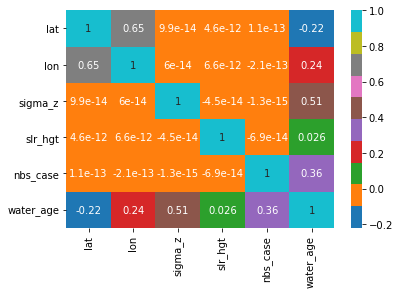

In [15]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='tab10', annot=True);

### 3.2 Histogram

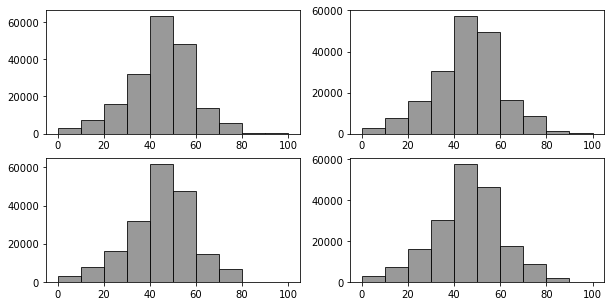

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0, 0].hist(df[df['slr_hgt']==0.0]['water_age'], color='gray', edgecolor='black', alpha=0.8, range=[0,100])
axs[1, 0].hist(df[df['slr_hgt']==0.3]['water_age'], color='gray', edgecolor='black', alpha=0.8, range=[0,100])
axs[0, 1].hist(df[df['slr_hgt']==1.0]['water_age'], color='gray', edgecolor='black', alpha=0.8, range=[0,100])
axs[1, 1].hist(df[df['slr_hgt']==2.0]['water_age'], color='gray', edgecolor='black', alpha=0.8, range=[0,100])
plt.show()

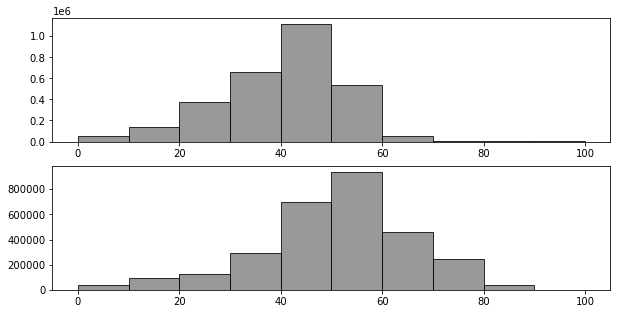

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].hist(df[df['nbs_case']==1]['water_age'], color='gray', edgecolor='black', alpha=0.8, range=[0,100])
axs[1].hist(df[df['nbs_case']==3]['water_age'], color='gray', edgecolor='black', alpha=0.8, range=[0,100])
plt.show()

In [18]:
def hisPlot(data=df,col_wrap=2,
            legend_title='NbS',legend_lables=['label 1', 'label 2'],
            savename="hist_nbs.png"):
    plt.clf()
    plt.figure(figsize=(12,6))
    g = sns.displot(data=data, x="water_age", kind="hist", hue="nbs_case", stat="density",
                col="slr_hgt",col_wrap=col_wrap,
                bins = 25,element="step",fill=True,
                palette="colorblind", height=4, aspect=1.5)
    sns.color_palette("husl", 9)
    sns.set(font_scale=1.3)
    plt.xlim(0, 100)
    g.set_axis_labels("Water age (day)", "Density")
    g.set_titles("{col_name} meters of SLR")
    g._legend.set_title(legend_title)
    new_labels = legend_lables
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    plt.savefig(savename,dpi=300)
    plt.show()
    
def kdePlot(data=df,col_wrap=2,
            legend_title='NbS',legend_lables=['label 1', 'label 2'],
            savename="kde_nbs.png"):
    plt.clf()
    plt.figure(figsize=(12,6))
    g = sns.displot(data=data, x="water_age", kind="kde", hue="nbs_case",
                    col="slr_hgt",col_wrap=col_wrap,
                    fill=True,
                    palette="colorblind", height=4, aspect=1.5)
    sns.color_palette("husl", 9)
    sns.set(font_scale=1.3)
    plt.xlim(0, 100)
    g.set_axis_labels("Water age (day)", "Density")
    g.set_titles("{col_name} meters of SLR")
    g._legend.set_title(legend_title)
    new_labels = legend_lables
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    plt.savefig(savename,dpi=300)
    plt.show()    

<Figure size 432x288 with 0 Axes>

<Figure size 864x432 with 0 Axes>

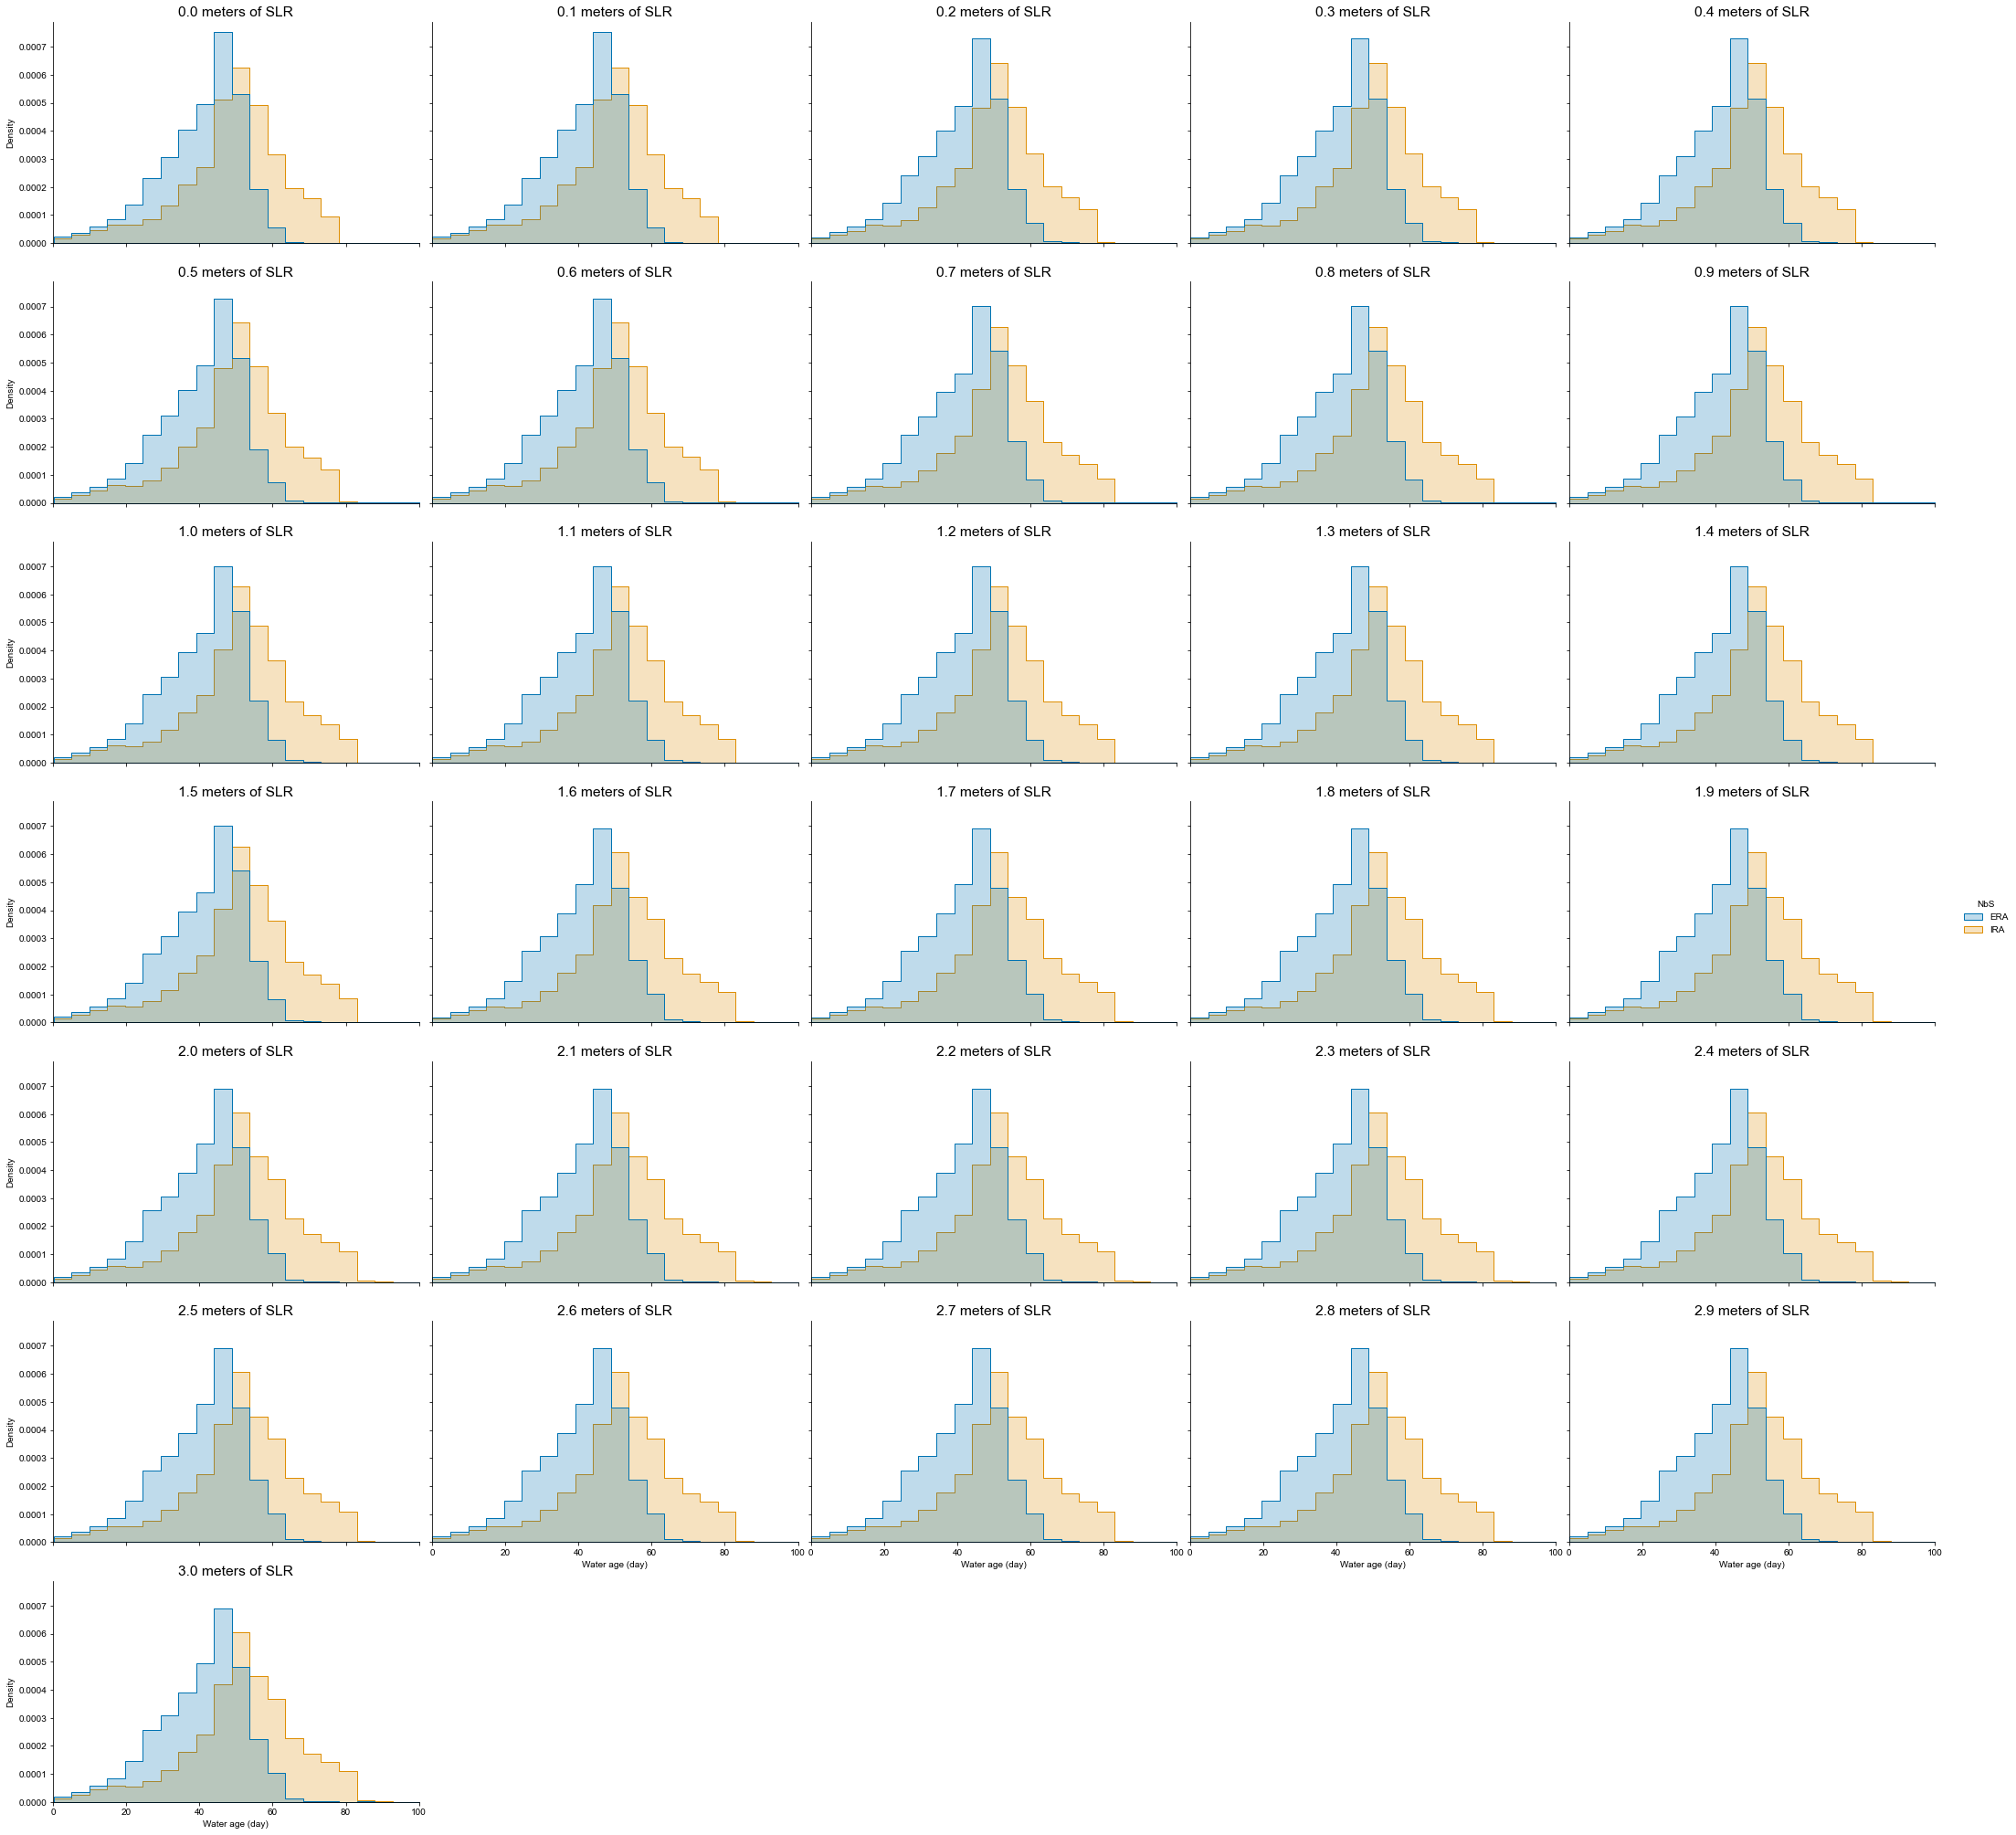

In [19]:
hisPlot(data=df,col_wrap=5,
        legend_title='NbS',legend_lables=['ERA', 'IRA'],
        savename="_hist_nbs.png")

<Figure size 432x288 with 0 Axes>

<Figure size 864x432 with 0 Axes>

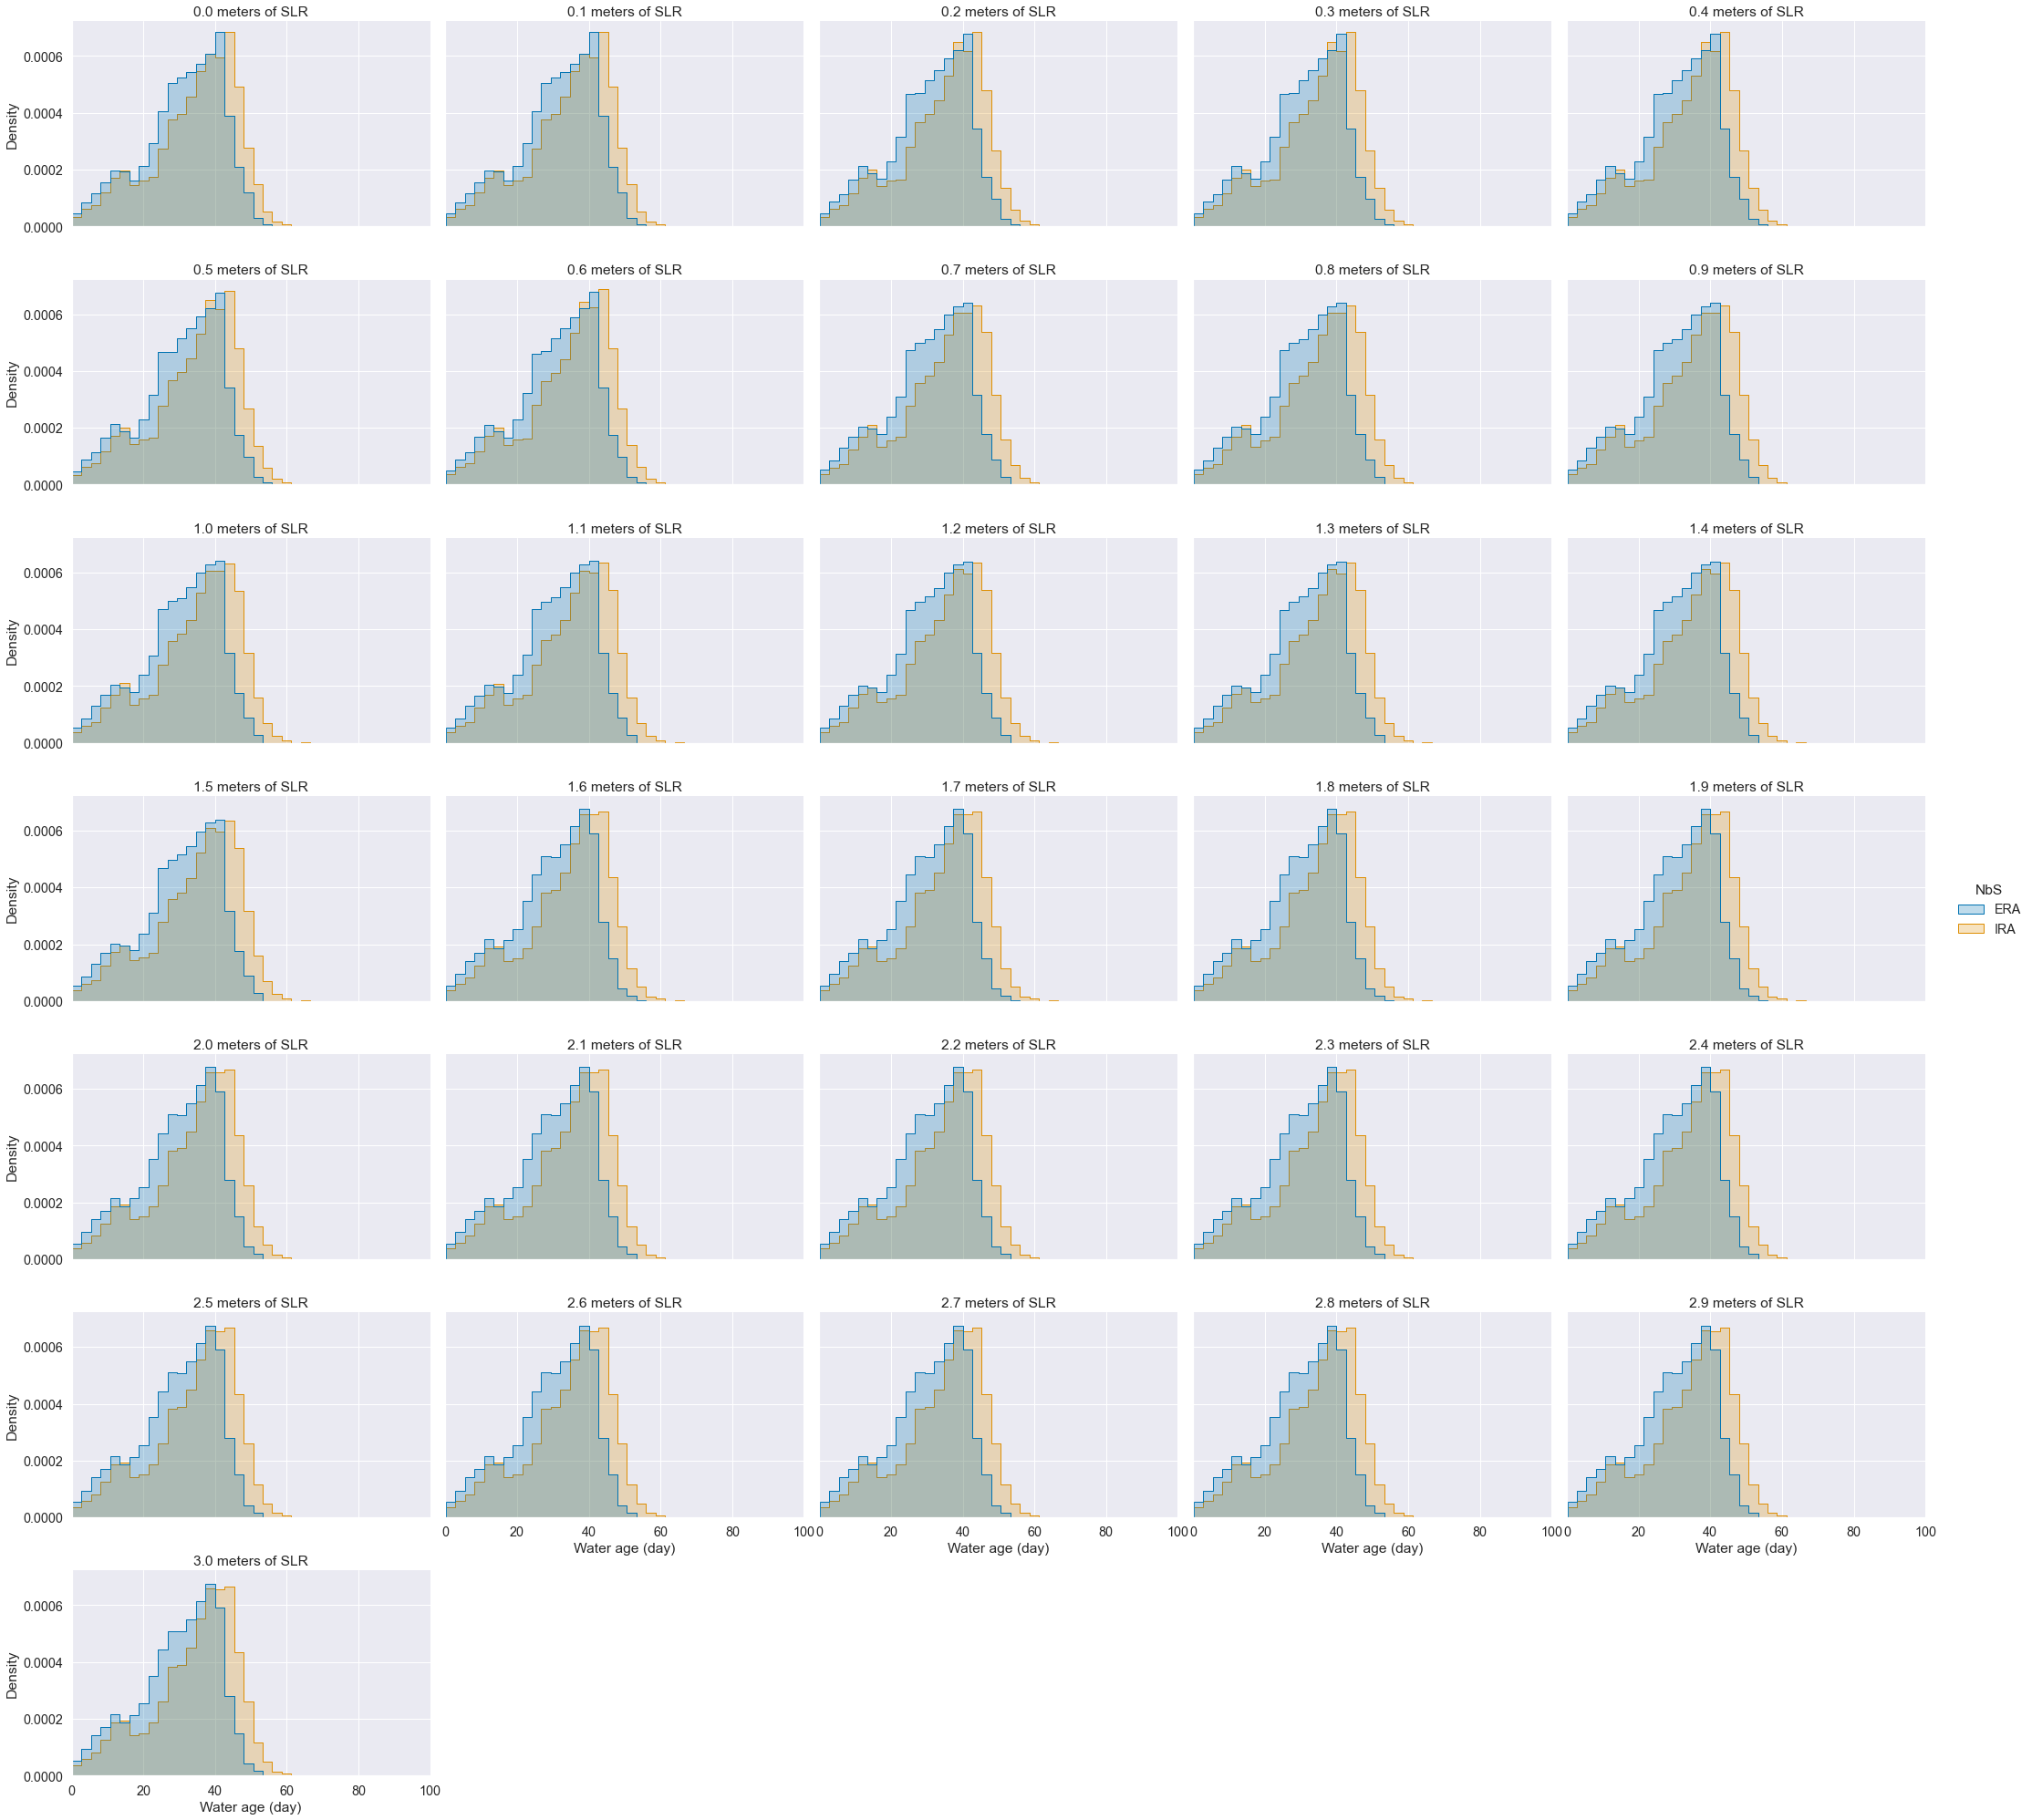

In [20]:
hisPlot(data=df[df.sigma_z == 1],col_wrap=5,
        legend_title='NbS',legend_lables=['ERA', 'IRA'],
        savename="_hist_nbs_01.png")

<Figure size 432x288 with 0 Axes>

<Figure size 864x432 with 0 Axes>

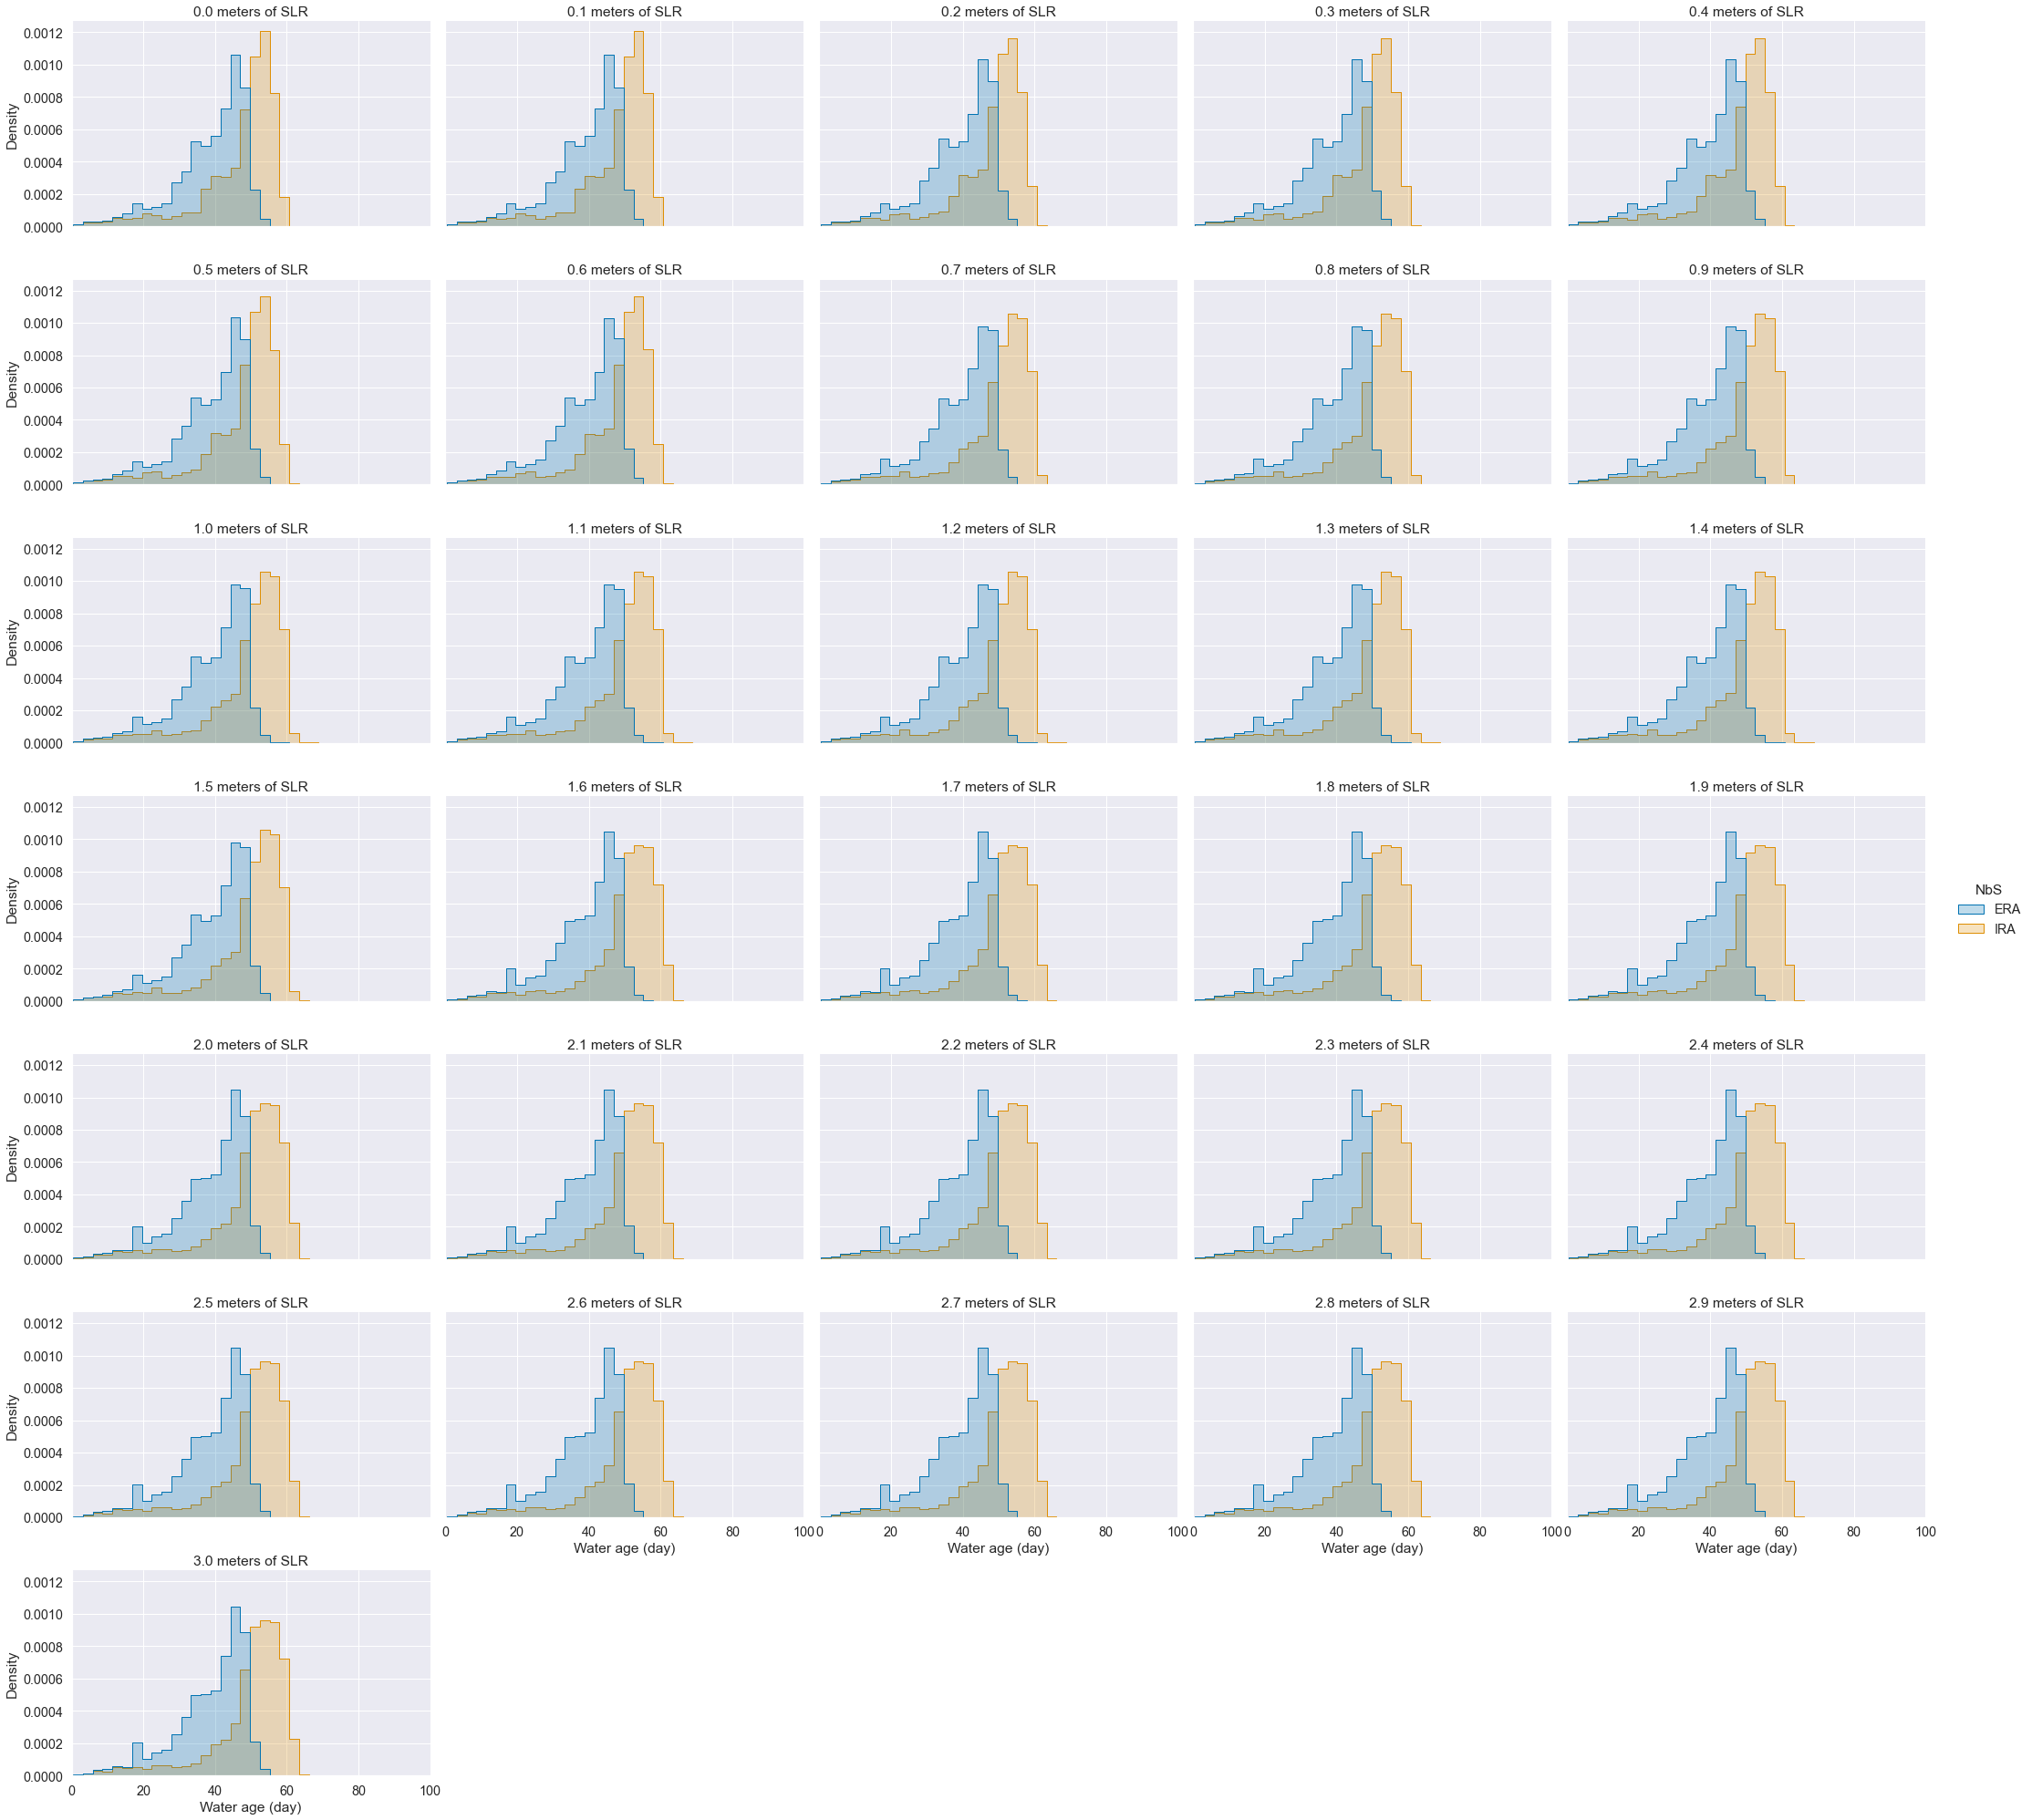

In [21]:
hisPlot(data=df[df.sigma_z == 8],col_wrap=5,
        legend_title='NbS',legend_lables=['ERA', 'IRA'],
        savename="_hist_nbs_08.png")

<Figure size 432x288 with 0 Axes>

<Figure size 864x432 with 0 Axes>

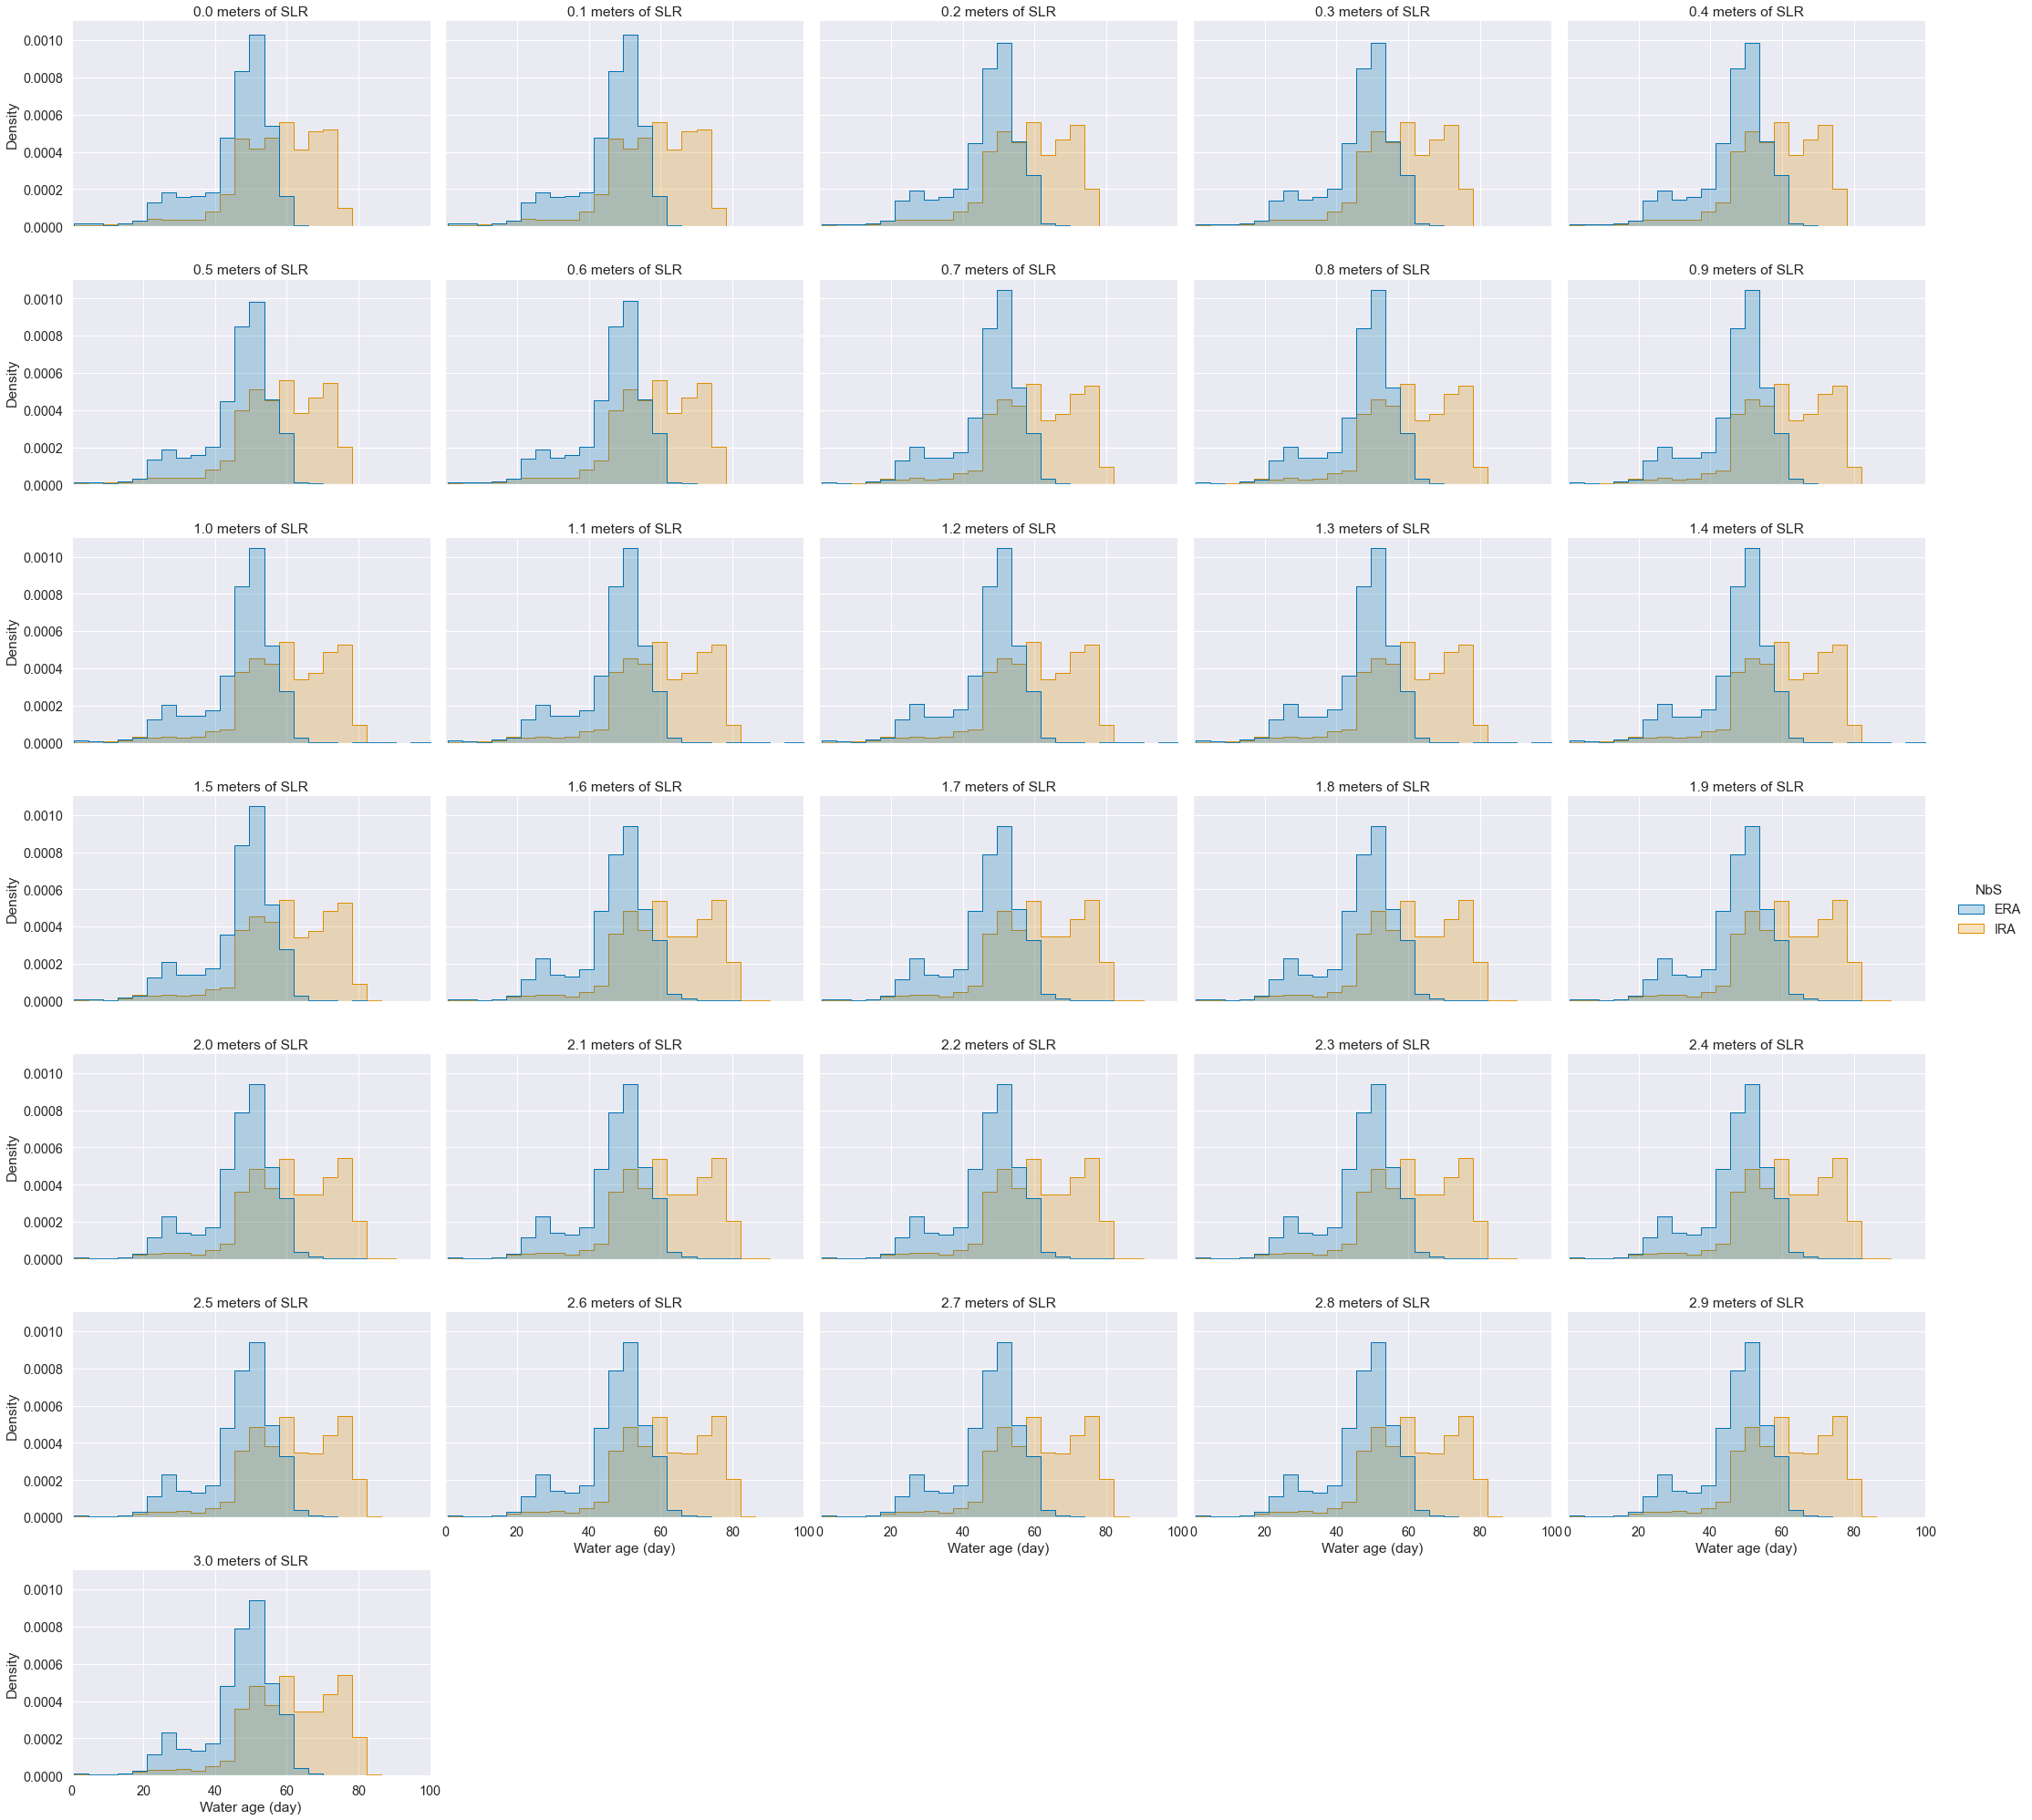

In [22]:
hisPlot(data=df[df.sigma_z == 16],col_wrap=5,
        legend_title='NbS',legend_lables=['ERA', 'IRA'],
        savename="_hist_nbs_16.png")

### 3.3 Jointplot

In [23]:
df_jp = df.rename(columns={"lat": "Lat.", 
                   "lon": "Lon.", 
                   "sigma_z": "Layer", 
                   "slr_hgt": "SLR", 
                   "nbs_case": "NbS", 
                   "water_age": "Water age"}, errors="raise")
df_jp.NbS.replace([1, 3], ['ERA', 'IRA'], inplace=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

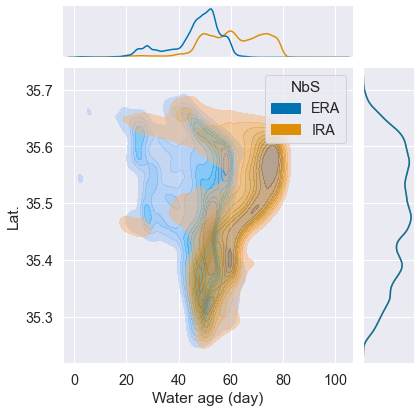

In [24]:
plt.clf()
plt.figure(figsize=(6,6))
g = sns.jointplot(data=df_jp[((df_jp.Layer == 16)) & 
                          ((df_jp.NbS=="ERA") | (df_jp.NbS=="IRA"))], 
                  y="Lat.", x="Water age",kind="kde",hue="NbS",
                  shade=True,alpha=.5,
                  palette="colorblind")
sns.set(font_scale=1.3)
g.set_axis_labels("Water age (day)", "Lat.")
plt.savefig("_joint_nbs_lat_16",dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

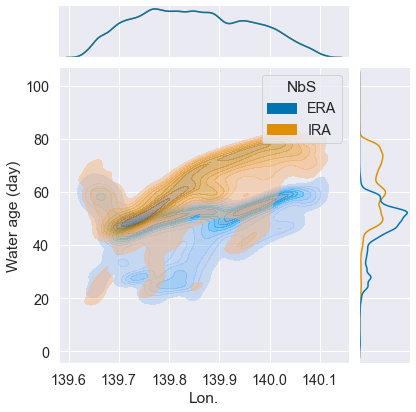

In [25]:
plt.clf()
plt.figure(figsize=(6,6))
g = sns.jointplot(data=df_jp[((df_jp.Layer == 16)) & 
                          ((df_jp.NbS=="ERA") | (df_jp.NbS=="IRA"))], 
                  y="Water age", x="Lon.",kind="kde",hue="NbS",
                  shade=True,alpha=.5,
                  palette="colorblind")
sns.set(font_scale=1.3)
g.set_axis_labels("Lon.", "Water age (day)")
plt.savefig("_joint_nbs_lon_16",dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

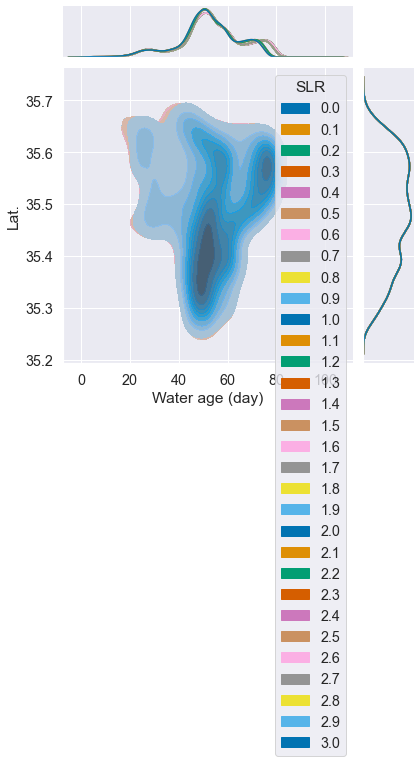

In [26]:
plt.clf()
plt.figure(figsize=(6,6))
g = sns.jointplot(data=df_jp[((df_jp.Layer == 16)) & 
                          ((df_jp.NbS=="ERA") | (df_jp.NbS=="IRA"))], 
                  y="Lat.", x="Water age",kind="kde",hue="SLR",
                  shade=True,alpha=.5,
                  palette="colorblind")
sns.set(font_scale=1.3)
g.set_axis_labels("Water age (day)", "Lat.")
# plt.savefig("joint_nbs_lat_16",dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

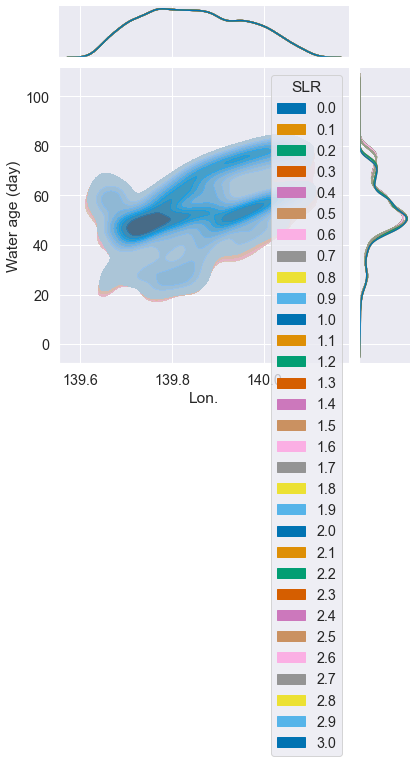

In [27]:
plt.clf()
plt.figure(figsize=(6,6))
g = sns.jointplot(data=df_jp[((df_jp.Layer == 16)) & 
                          ((df_jp.NbS=="ERA") | (df_jp.NbS=="IRA"))], 
                  y="Water age", x="Lon.",kind="kde",hue="SLR",
                  shade=True,alpha=.5,
                  palette="colorblind")
sns.set(font_scale=1.3)
g.set_axis_labels("Lon.", "Water age (day)")
# plt.savefig("joint_nbs_lon_16",dpi=300)
plt.show()

### 3.4 Boxplot

<Figure size 432x288 with 0 Axes>

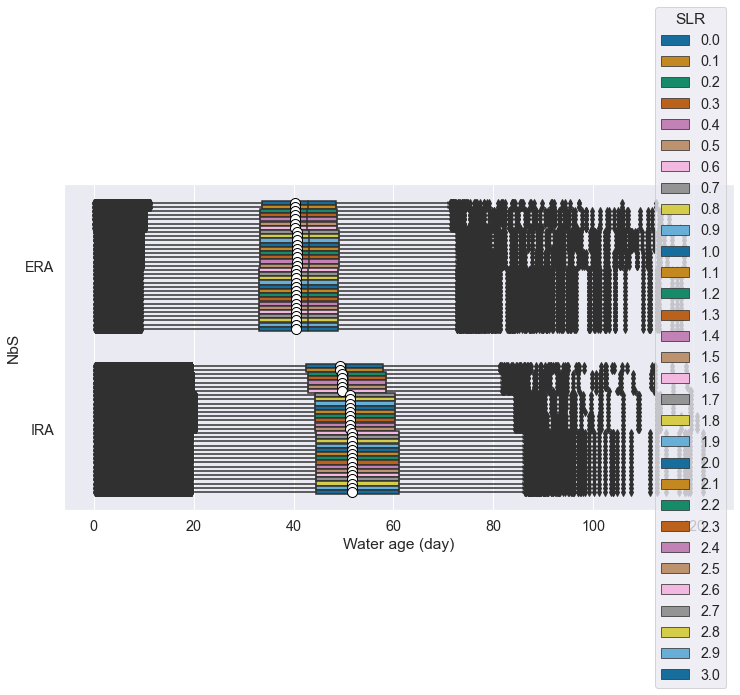

In [30]:
plt.clf()
plt.figure(figsize=(12,6))
g = sns.boxplot(data=df_jp, y="NbS", x="Water age", hue="SLR",
                palette="colorblind",
                dodge=True,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
g.legend(loc='center right',ncol=1,title="SLR")
sns.set(font_scale=1.3)
plt.xlabel("Water age (day)")
plt.ylabel("NbS")
#plt.title("SLR Bias in Water age")
plt.savefig("_box_slr_bias.png",dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

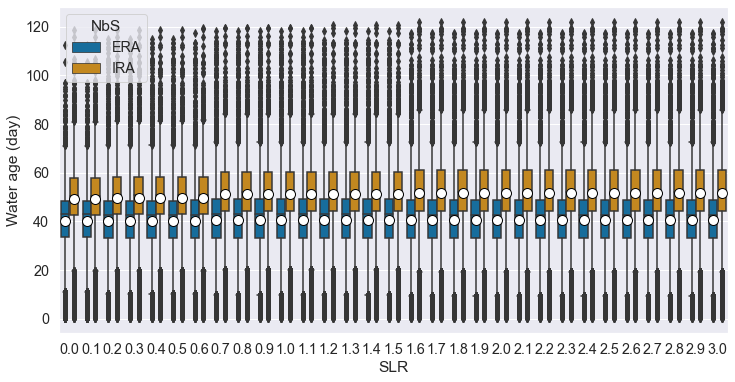

In [32]:
plt.clf()
plt.figure(figsize=(12,6))
g = sns.boxplot(data=df_jp, x="SLR", y="Water age", hue="NbS",
                palette="colorblind",
                dodge=True,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
sns.set(font_scale=1.3)
plt.xlabel("SLR")
plt.ylabel("Water age (day)")
#plt.title("SLR Bias in Water age")
plt.savefig("_box_nbs_bias.png",dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

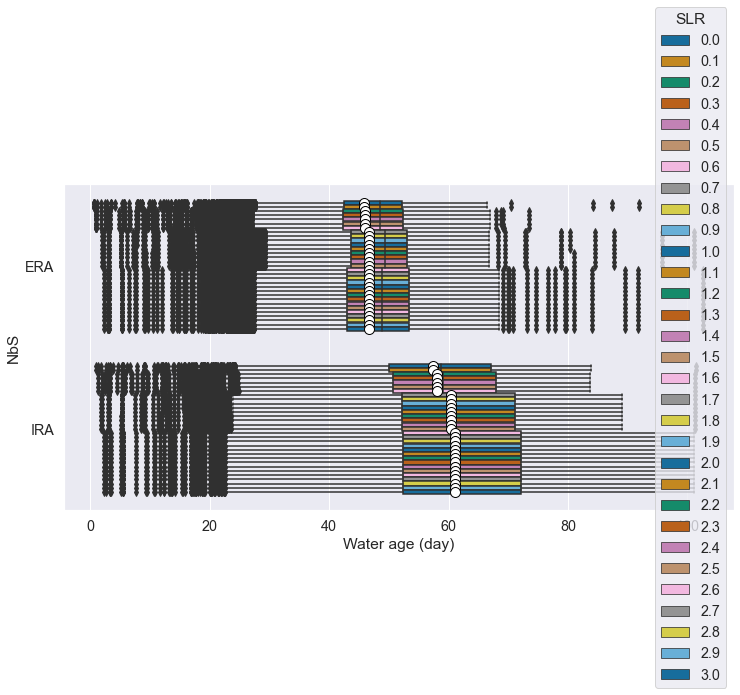

In [33]:
plt.clf()
plt.figure(figsize=(12,6))
g = sns.boxplot(data=df_jp[df_jp.Layer==16], y="NbS", x="Water age", hue="SLR",
                palette="colorblind",
                dodge=True,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
g.legend(loc='center right',ncol=1,title="SLR")
sns.set(font_scale=1.3)
plt.xlabel("Water age (day)")
plt.ylabel("NbS")
#plt.title("SLR Bias in Water age")
plt.savefig("_box_slr_bias_16.png",dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

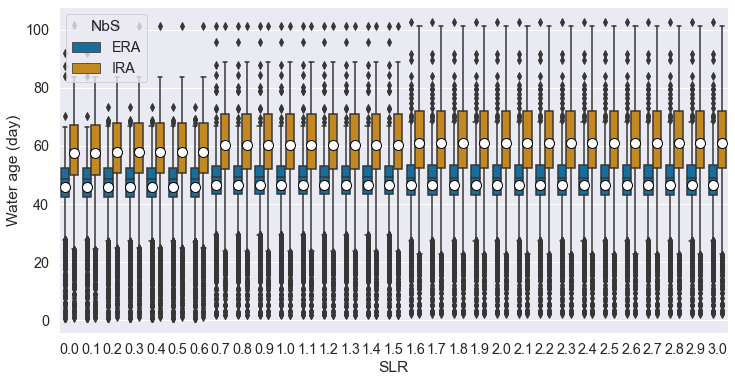

In [34]:
plt.clf()
plt.figure(figsize=(12,6))
g = sns.boxplot(data=df_jp[df_jp.Layer==16], x="SLR", y="Water age", hue="NbS",
                palette="colorblind",
                dodge=True,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
sns.set(font_scale=1.3)
plt.xlabel("SLR")
plt.ylabel("Water age (day)")
#plt.title("SLR Bias in Water age")
plt.savefig("_box_nbs_bias_16.png",dpi=300)
plt.show()

<AxesSubplot:xlabel='SLR', ylabel='Water age'>

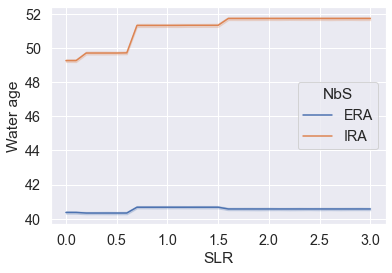

In [37]:
sns.lineplot(data=df_jp, x="SLR", y="Water age", hue="NbS")